# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.91', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
trainset, valset = raw_to_dict(data_mode = "small")

100%|██████████| 1000/1000 [00:00<00:00, 1322707.03it/s]


>> Loading msimut at /home/kien/Documents/My Project/ucla-cs168/data/msimut_small
>> Total running 1000

>> Loading msimut at /home/kien/Documents/My Project/ucla-cs168/data/mss_small
>> Total running 1000

>> Splitting the dataset

>> From dictionary to data instance

>> Done!


In [6]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(56, 36)

torch.Size([32, 3, 224, 224]) torch.Size([32])


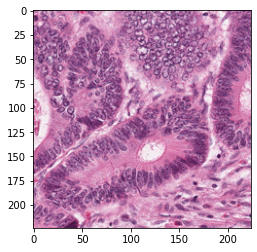

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Baseline Model

In [8]:
from trainer.baseline_trainer import BaseLineTrainer

In [9]:
baseline_trainer = BaseLineTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = baseline_trainer.get_max_epochs()

In [10]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "baseline")
trainer = pl.Trainer(nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                     logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning finder

In [11]:
lr_finder = trainer.lr_find(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | CrossEntropyLoss  | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

INFO:lightning:LR finder stopped early due to diverging loss.


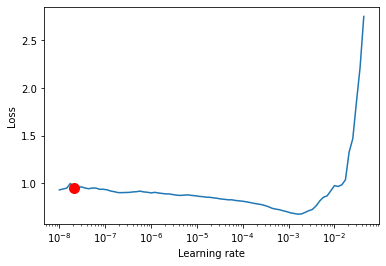

In [12]:
fig = lr_finder.plot(suggest=True)

In [13]:
baseline_trainer.base_lr = 1e-4
baseline_trainer.max_lr = 8e-4
baseline_trainer.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-08
    initial_lr: 3.2e-05
    lr: 3.200000000000002e-05
    max_lr: 0.0008
    max_momentum: 0.95
    min_lr: 3.1999999999999997e-09
    weight_decay: 0
)

## Train model

In [14]:
trainer.fit(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | CrossEntropyLoss  | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

1